#Predicting the West Nile Virus in Chicago

This notebook presents analyses of incidents of the West Nile Virus (WNV) in Chicago during the year 2007-2013 as part of a [Kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/). We are offered records concerning mosquito traps, specifically data on datetime of a trap event, location, species of mosquito trapped, number of mosquitos trapped, and whether any of those mosquitos carried WNV, along with data on weather for the Chicago area during the same period. Finally, we also given data on spray efforts undertaken by the City of Chicago for part of this timeframe. In the testing set, we are given the same information, less the spray data -- and, of course, WNV class labels for the trap records.

-----
## Setup

In [1]:
# Import some necessary packages
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

%matplotlib inline

In [2]:
# seaborn defaults
sns.set_style("darkgrid")
sns.set_palette("muted")

In [3]:
# Get the trap data
trap_training_data = pd.read_csv("../input/train.csv")

# Get the weather data; missing values are coded as "M" and trace precipitation is "T"
weather_data = pd.read_csv("../input/weather.csv", na_values=["M", "T"])

# Get the spray data
spray_data = pd.read_csv("../input/spray.csv")

----
## Exploratory Data Analysis: One Variable

Let's start by looking at each data source and some variables of interest.

###Trap data

In [4]:
# Take a peek at the data
trap_training_data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
# Convert dates to datetime objects
trap_training_data["Date"] = pd.to_datetime(trap_training_data["Date"].values)

In [6]:
# Get summary stats
trap_training_data[["Date", "Species", "Trap", "NumMosquitos", "WnvPresent"]].describe(include="all")

,Date,Species,Trap,NumMosquitos,WnvPresent
count,10506,10506,10506,10506.000000,10506.000000
unique,95,7,136,NaN,NaN
top,2007-08-01 00:00:00,CULEX PIPIENS/RESTUANS,T900,NaN,NaN
freq,551,4752,750,NaN,NaN
first,2007-05-29 00:00:00,NaN,NaN,NaN,NaN
last,2013-09-26 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.853512,0.052446
std,NaN,NaN,NaN,16.133816,0.222936
min,NaN,NaN,NaN,1.000000,0.000000
25%,NaN,NaN,NaN,2.000000,0.000000


Initial thoughts on the trap data: 

* There are only 95 unique dates over a six-year period.
* Address, Street, and AddressNumberAndStreet look fairly unstructured and difficult to work with.
* There are only 7 species of mosquito.
* The maximum number of species per trap is 50. This, we are told, is an artifact of how the data were collected. If more than 50 mosquitos appear in a trap, that record gets broken out into multiple records.
* In only ~5% of trap events are there mosquitos with WNV (i.e. WnvPresent == 1). Our data are imbalanced. This is something to keep in mind as we work toward a model.

Let's see how much data we're missing.

In [7]:
# Proportion of missing data per column
trap_training_data.isnull().sum(axis=0) / len(trap_training_data) * 1.0

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: float64

Since there's no missing data, let's look at some promising variables for the trap data.

#### Datetime

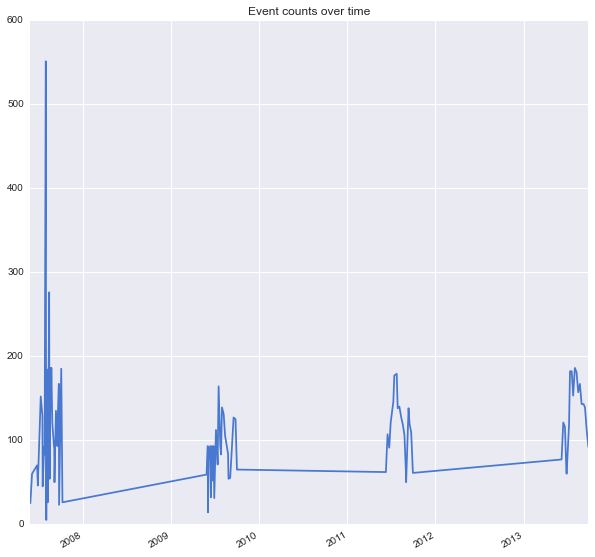

In [8]:
# Distribution of records over time
figsize(10,10)
trap_training_data["Date"].value_counts().plot()
plt.title("Event counts over time")

We see records in ~100-day chunks rougly every two years. So it appears that records were collected during the warm months, when one would expect mosquitos to be in a city. (The gaps between years are where our testing data resides.)

We also see that most days have 200 or fewer trap records. There are some outliers as well -- that is, days with an inordinately large number of trap records. These are toward the start of the record keeping.

Within each year, it looks like there are peaks and valleys. Let's take a closer look.

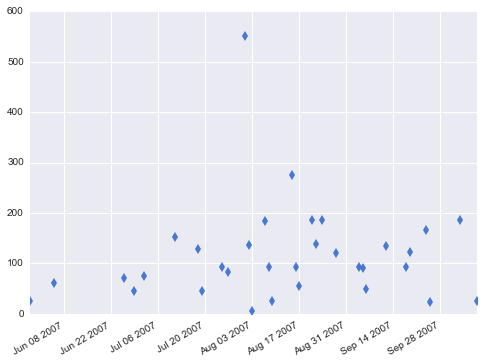

In [9]:
figsize(8, 6)
trap_training_data[trap_training_data.Date.dt.year == 2007].Date.value_counts().plot(style='d')

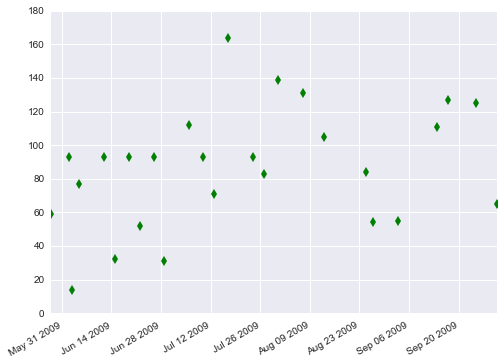

In [10]:
trap_training_data[trap_training_data.Date.dt.year == 2009].Date.value_counts().plot(style='gd')

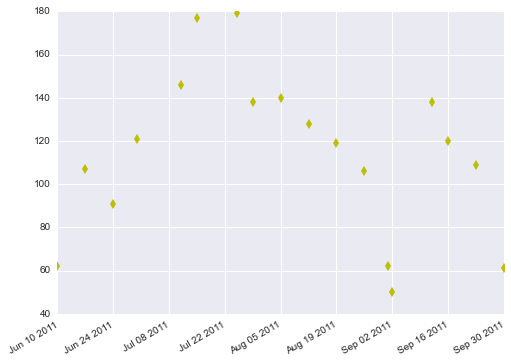

In [11]:
trap_training_data[trap_training_data.Date.dt.year == 2011].Date.value_counts().plot(style='yd')

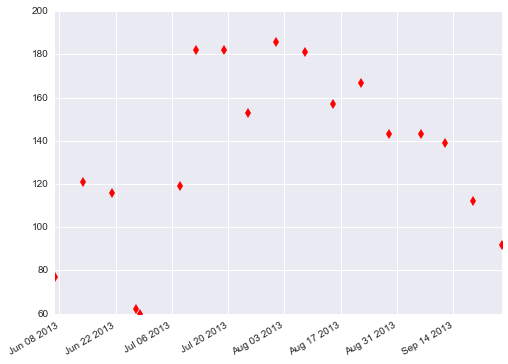

In [12]:
trap_training_data[trap_training_data.Date.dt.year == 2013].Date.value_counts().plot(style='rd')

Most of the dates with trap records are non-contiguous. In 2011 and 2013, the trap events seem almost, but not quite, regularly spaced, as if traps were checked regularly and records logged only then (even if mosquitos were coming in more frequently). In other years, though, there is no apparent periodicity, and the randomness of the dates seems like it might reflect actual mosquito abundances.

Note, too, that since there are 10k+ events and only 95 unique days, there must be many events on the same day.

In [13]:
datesum, datecount = 0, 0 
for i in range(2007, 2014, 2):
    for j in range(1, trap_training_data.shape[0]-1):
        if trap_training_data.ix[j]["Date"].year == i:
            datesum += (trap_training_data.ix[j]["Date"] - trap_training_data.ix[j-1]["Date"]).days
            datecount += 1
    print "Mean days between trap events in", i, ":", datesum * 1.0 / datecount
    datesum, datecount = 0, 0

Mean days between trap events in 2007 : 0.0349081364829
Mean days between trap events in 2009 : 0.32147621165
Mean days between trap events in 2011 : 0.354917234664
Mean days between trap events in 2013 : 0.304056879967


Indeed, the mean inter-trap-event time is less than a day in every year of the training set.

#### Number of mosquitos per trap event

In [14]:
trap_training_data['NumMosquitos'].describe()

count    10506.000000
mean        12.853512
std         16.133816
min          1.000000
25%          2.000000
50%          5.000000
75%         17.000000
max         50.000000
Name: NumMosquitos, dtype: float64

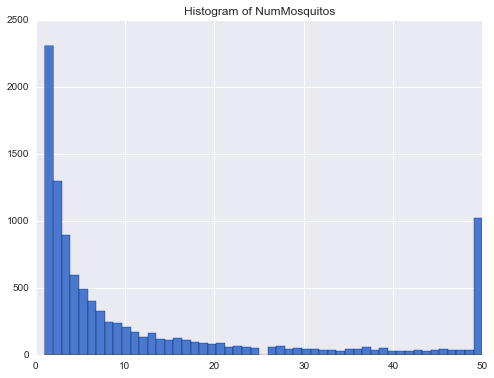

In [15]:
plt.hist(trap_training_data["NumMosquitos"], bins=51)
plt.title("Histogram of NumMosquitos")

The uptick at 50 is an artifact of how the data were collected. As described earlier, if more than 50 mosquitos were collected in a trap, that record got partitioned into multiple records.

Given that we won't have access to this variable in the test set *and* that there are so many days without trap records (where x == 0), it's worth thinking about how we might fit NumMosquitos to a known distribution. If we ignore the spike at 50, the distribution looks exponential. We probably can't assume that mosquito trap events are independent, if for no other reason than seasonal effects, but let's try a fit anyway.

We'll first smooth out the artifact at x == 50 in the process. by grouping all events for a given trap and species together *by day*. 

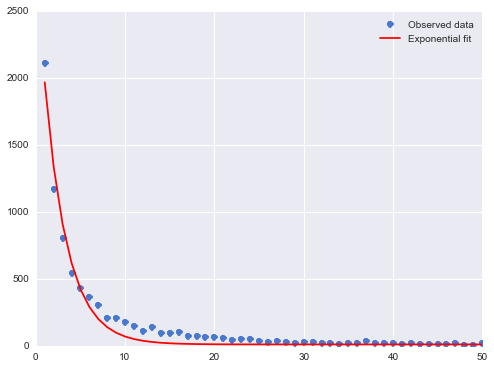

In [16]:
numMosquitosPoisson = trap_training_data.groupby(["Date", "Trap", "Species"]).sum()
tmp = numMosquitosPoisson["NumMosquitos"].value_counts().sort_index()

from scipy.optimize import curve_fit

def expon_fit(x, a, b, c):
    return a * b * np.exp(-b * x) + c

expon_popt, expon_pcov = curve_fit(expon_fit, tmp.index, tmp)

tmp.plot(style='o')
plt.plot(tmp.index, expon_fit(tmp.index, *expon_popt), 'r-')
plt.xlim(0,50)
plt.legend(["Observed data", "Exponential fit"])

The fit looks reasonable. It decays more quickly than the observed data do; perhaps this is the interdependence of events -- or, what might be the same thing, seasonality -- expressing itself. Nevertheless, this fit might prove useful down the road.

#### Number of trap events by species

In [17]:
trap_training_data["Species"].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
dtype: int64

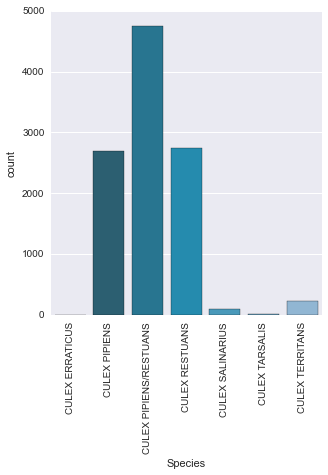

In [18]:
sns.factorplot("Species", data=trap_training_data, palette="PuBuGn_d")
plt.xticks(rotation=90)
plt.show()

There's a huge imbalance here. The last four species represent only ~1% of the species trapped, and *C. Erraticus* had only **one** occurrence in several years' worth of data!

#### Latitude and longitude

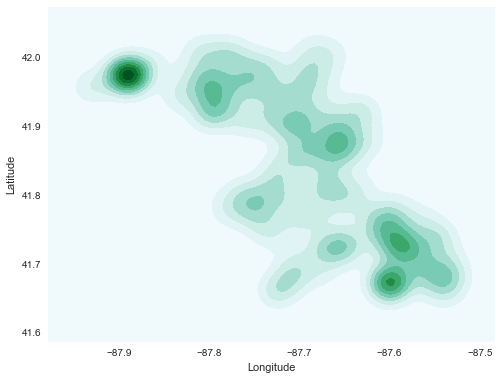

In [19]:
# 2D distribution of latitude & longitude 
sns.kdeplot(trap_training_data["Longitude"], trap_training_data["Latitude"], shade=True)
plt.show()

We can see some specter of Chicago's geography (slightly rotated) in the 2D picture above. Traps are not uniformly distributed across the city. A preponderance of trap events seem to be at O'Hare Airport, in the top left corner, and there's also a high density on the South Side. 

Latitude and longitude in their raw form will no doubt prove problematic for a model. Some sort of clustering as a preprocessing step might be a good idea. Using trap ids in favor of lat/lon is also an option, although the number of traps is on the order of 100 and creating dummy variables for each of these will take us into high-dimensional territory.

#### Specific traps

What is the distribution of event counts across traps?

In [20]:
trap_training_data["Trap"].value_counts().describe()

count    136.000000
mean      77.250000
std       87.409276
min        2.000000
25%       23.000000
50%       64.000000
75%      104.250000
max      750.000000
dtype: float64

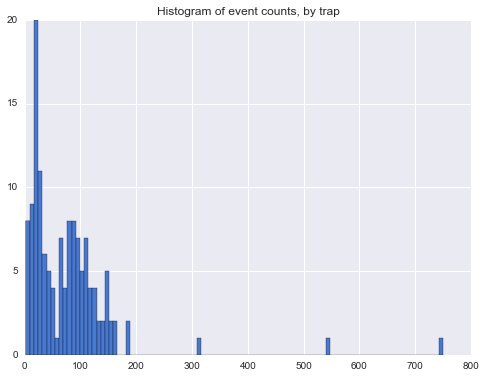

In [21]:
plt.hist(trap_training_data["Trap"].value_counts(), bins=100)
plt.title("Histogram of event counts, by trap")

This is far from a normal distribution. There are a few traps that get an inordinate number of events.

### Weather data

Next, let's examine possible features from our weather dataset.

In [22]:
weather_data["Date"] = pd.to_datetime(weather_data["Date"].values)

In [23]:
# Take a peek at the data
weather_data.columns

Index([u'Station', u'Date', u'Tmax', u'Tmin', u'Tavg', u'Depart', u'DewPoint', u'WetBulb', u'Heat', u'Cool', u'Sunrise', u'Sunset', u'CodeSum', u'Depth', u'Water1', u'SnowFall', u'PrecipTotal', u'StnPressure', u'SeaLevel', u'ResultSpeed', u'ResultDir', u'AvgSpeed'], dtype='object')

In [24]:
weather_data.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,NaN,51,57,0,3,...,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,NaN,42,47,13,0,...,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9


In [25]:
# Get summary stats
weather_data.describe(include="all")

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
count,2944.000000,2944,2944.000000,2944.000000,2933.000000,1472.000000,2944.000000,2940.000000,2933.000000,2933.000000,...,2944,1472,0,1472,2942,2940.000000,2935.000000,2944.000000,2944.000000,2941.000000
unique,NaN,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98,NaN,NaN,3,167,NaN,NaN,NaN,NaN,NaN
top,NaN,2014-08-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,NaN,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN
freq,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1609,NaN,NaN,1459,1577,NaN,NaN,NaN,NaN,NaN
first,NaN,2007-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2014-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.500000,NaN,76.166101,57.810462,67.240027,1.954484,53.457880,59.310884,3.407092,5.647119,...,NaN,0,NaN,NaN,NaN,29.284429,29.968129,6.960666,17.494905,8.580449
std,0.500085,NaN,11.461970,10.381939,10.545442,6.841110,10.675181,9.286742,5.953203,6.105087,...,NaN,0,NaN,NaN,NaN,0.158543,0.158597,3.587527,10.063609,3.147300
min,1.000000,NaN,41.000000,29.000000,36.000000,-17.000000,22.000000,32.000000,0.000000,0.000000,...,NaN,0,NaN,NaN,NaN,28.550000,29.230000,0.100000,1.000000,1.700000
25%,1.000000,NaN,69.000000,50.000000,60.000000,-3.000000,46.000000,53.000000,0.000000,0.000000,...,NaN,0,NaN,NaN,NaN,29.190000,29.870000,4.300000,7.000000,6.300000


The weather data set is more comprehensive in terms of its date ranges: 1472 unique dates across 7 years. It seems like it might contain data for all the "gap" dates from the trap dataset, though only for the warm months.

In [26]:
# Determine prevalence of missing data
weather_data.isnull().sum(axis=0) / len(weather_data)

Station        0.000000
Date           0.000000
Tmax           0.000000
Tmin           0.000000
Tavg           0.003736
Depart         0.500000
DewPoint       0.000000
WetBulb        0.001359
Heat           0.003736
Cool           0.003736
Sunrise        0.000000
Sunset         0.000000
CodeSum        0.000000
Depth          0.500000
Water1         1.000000
SnowFall       0.500000
PrecipTotal    0.000679
StnPressure    0.001359
SeaLevel       0.003057
ResultSpeed    0.000000
ResultDir      0.000000
AvgSpeed       0.001019
dtype: float64

We don't want to do too much imputation. This rules out several potential predictor variables, such as Depart (i.e. departure from normal temperature), Depth (i.e. depth of snow/ice on the ground), Waterl (i.e. equivalent of snow depth, but for liquid water), and SnowFall. Many of these aren't pertinent during the warm months, of course.

As a first pass, the predictors that seem most of interest (and least in need of imputation) are:
* Tavg :: the average temperature for the day. We can impute any missing values using the surrounding days.
* DewPoint :: a measure of humidity, which factors into mosquito breeding habits. According to the documentation, "hot and dry" conditions are supposed to be more favorable to mosquitos than "cold and wet" conditions.
* PrecipTotal :: also relevant for mosquito breeding. A few missing values, but we can impute.
* AvgSpeed :: average wind speed. Mosquito tend to breed more in still air. A few missing values here as well. 

We may also wish to consider Station, i.e. the station at which the weather data were recorded. However, there are only two stations, and they are at Chicago's two main airports, neither of which is near the water. Also, both stations are equally well represented in the data: 

In [27]:
weather_data["Station"].value_counts()

1    1472
2    1472
dtype: int64

For the moment, let's not worry about this variable. 

Next, let's impute missing values using the value from the day before. This will handle the less than 1% of Tavg, AvgSpeed, and PrecipTotal values that are missing.

In [28]:
weather_data = weather_data.fillna(method="ffill")

#### Average temperature

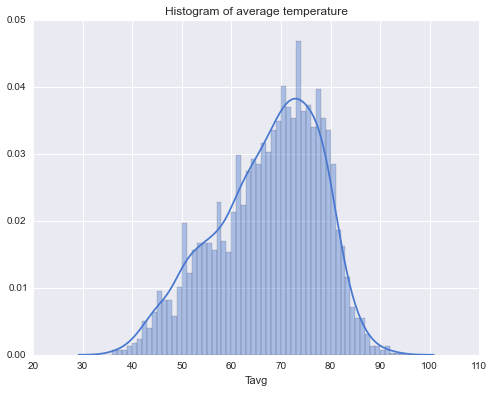

In [29]:
sns.distplot(weather_data["Tavg"], bins=np.arange(30,100))
plt.title("Histogram of average temperature")
plt.show()

Nothing too shocking here. The distribution seems well-behaved, with a slight negative skew. Is it different from year to year?

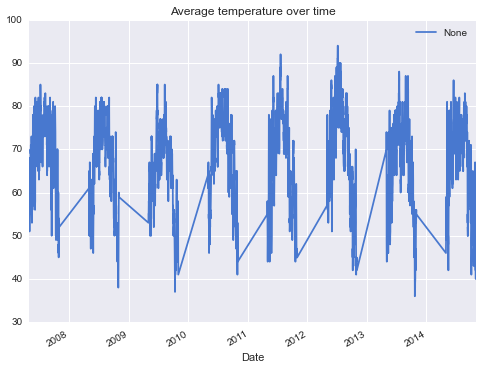

In [30]:
weather_data.plot("Date", "Tavg")
plt.title("Average temperature over time")

In [31]:
weatherByYear = weather_data.groupby(weather_data.Date.dt.year)
weatherByYear["Tavg"].mean()

2007    69.160326
2008    66.057065
2009    64.364130
2010    68.687500
2011    67.005435
2012    69.070652
2013    66.880435
2014    66.562500
Name: Tavg, dtype: float64

On average, some years are a little warmer (2012), and some are a little cooler (2009).

#### Dew point

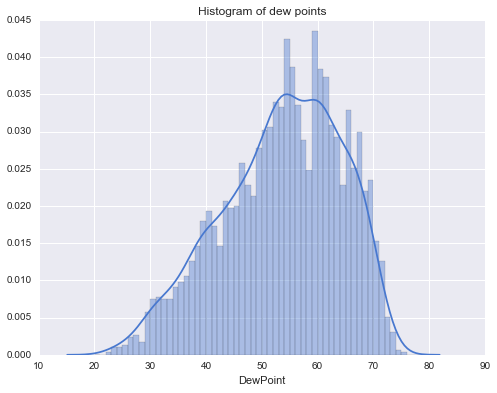

In [32]:
sns.distplot(weather_data["DewPoint"], bins=np.arange(20,80))
plt.title("Histogram of dew points")
plt.show()

Another normal-ish distribution, with some noise near the peak.

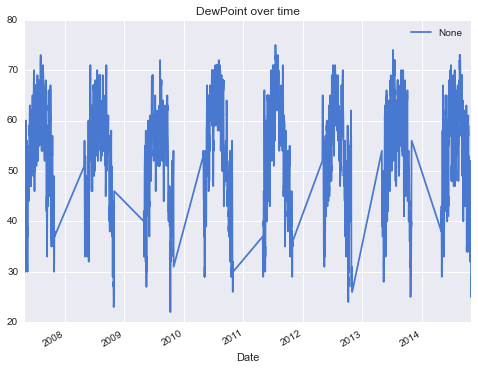

In [33]:
weather_data.plot("Date", "DewPoint")
plt.title("DewPoint over time")

In [34]:
weatherByYear["DewPoint"].mean()

2007    54.236413
2008    52.733696
2009    51.904891
2010    54.785326
2011    54.396739
2012    52.475543
2013    53.983696
2014    53.146739
Name: DewPoint, dtype: float64

#### Precipitation

In [35]:
weather_data["PrecipTotal"].describe()

count     2944
unique     167
top       0.00
freq      1579
Name: PrecipTotal, dtype: object

PrecipTotal is not coming across as a float, because "trace" precipitation is encoded as "T" in the original dataset. Let's fix that.

In [36]:
def trace_precip(s):
    try: 
        return float(s)
    except ValueError:
        s = 0.01
        return s

In [37]:
weather_data["PrecipTotal"] = weather_data["PrecipTotal"].apply(trace_precip)

In [38]:
# Confirm that it worked
weather_data["PrecipTotal"].describe()

count    2944.00000
mean        0.13232
std         0.39286
min         0.00000
25%         0.00000
50%         0.00000
75%         0.06000
max         6.86000
Name: PrecipTotal, dtype: float64

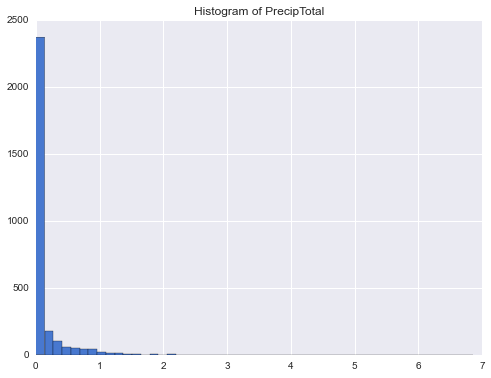

In [39]:
plt.hist(weather_data["PrecipTotal"], bins=50)
plt.title("Histogram of PrecipTotal")

This looks exponential.

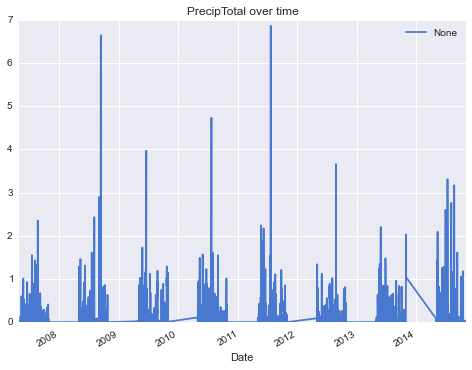

In [40]:
weather_data.plot("Date", "PrecipTotal")
plt.title("PrecipTotal over time")

In [41]:
weatherByYear["PrecipTotal"].mean()

2007    0.109701
2008    0.155516
2009    0.130897
2010    0.154158
2011    0.144783
2012    0.091603
2013    0.109973
2014    0.161929
Name: PrecipTotal, dtype: float64

So the summers of 2007 and 2013 were relatively dry compared to, say, 2008 and 2011.

#### Wind speed

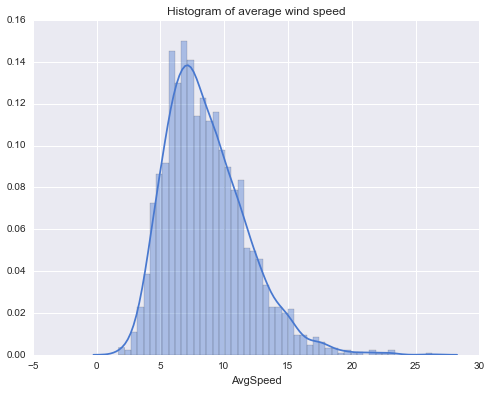

In [42]:
sns.distplot(weather_data["AvgSpeed"], bins=50)
plt.title("Histogram of average wind speed")
plt.show()

Fairly normal, with a positive skew and a long tail.

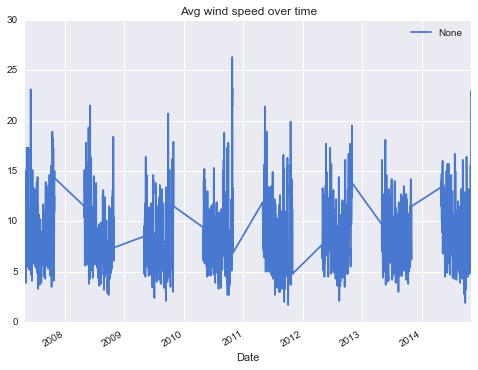

In [43]:
weather_data.plot("Date", "AvgSpeed")
plt.title("Avg wind speed over time")

In [44]:
weatherByYear["AvgSpeed"].mean()

2007    8.798098
2008    8.520924
2009    8.102174
2010    8.485870
2011    8.365217
2012    9.060870
2013    8.317935
2014    8.981522
Name: AvgSpeed, dtype: float64

### Spray data

Finally, let's take a look at the spray data.

In [45]:
spray_data["Date"] = pd.to_datetime(spray_data["Date"].values)

In [46]:
# Overview
spray_data.describe(include="all")

,Date,Time,Latitude,Longitude
count,14835,14251,14835.000000,14835.000000
unique,10,8583,NaN,NaN
top,2013-08-15 00:00:00,7:44:32 PM,NaN,NaN
freq,2668,541,NaN,NaN
first,2011-08-29 00:00:00,NaN,NaN,NaN
last,2013-09-05 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,41.904828,-87.736690
std,NaN,NaN,0.104381,0.067292
min,NaN,NaN,41.713925,-88.096468
25%,NaN,NaN,41.785001,-87.794225


In [47]:
print "First spray date: ", spray_data["Date"].min()
print "Last date: ", spray_data["Date"].max()

First spray date:  2011-08-29 00:00:00
Last date:  2013-09-05 00:00:00


Two things jump out:
1. There are only 10 unique days across 6 years!
2. There is no information on quantity, spray type, etc. We get only date, time, and location information.

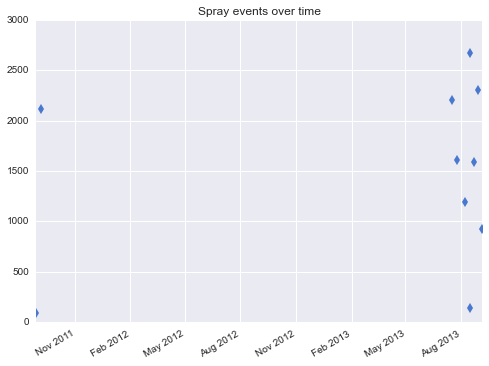

In [48]:
spray_data.Date.value_counts().plot(style='d')
plt.title("Spray events over time")

There was no spraying for the first 4 years of our trap data set. Then there was only a short burst of spraying, after which spraying didn't pick up until the last year of the trap data. We also know from external sources that spraying wasn't deemed to be particularly effective. So it's questionable how helpful spray data will be for our purposes.

More importantly, spray data isn't available in the testing set, so we won't be able to incorporate it into our model. Let's ignore it going forward.

---
## Exploratory Data Analysis: Multiple Dimensions

We now have a basic overview of our dataset. The trap data set has two unbalanced classes in the response variable, some unruly distributions in the predictors, and a few data collection quirks. The weather data set, by contrast, is well behaved. Finally, the spray data aren't useful for prediction purposes.

Next, we want to start seeing how each potential predictor correlates with our response variable. 

A word of caution before proceeding, though. The test set contains records for the "gap" years. However, not all of the records in the test set are real — the trap testing set represent "possible" records, only some of which are real. As a result, we can't take any the presence of any test record as some measure of ground truth for use in a model, nor can we infer any trends from their presence. Additionally, even in these "possible" records, we will **not** be given the number of mosquitos, so our model must not rely on this variable directly.

In [49]:
# Merge trap and weather data sets; pick only one station
trapWeather = pd.merge(trap_training_data, weather_data[weather_data["Station"] == 1], on = "Date")
trapWeather.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,BR HZ,0,NaN,0.0,0,29.39,30.11,5.8,18,6.5


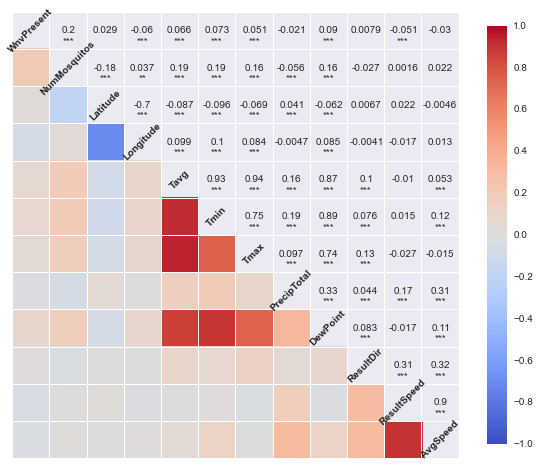

In [50]:
# Get pairwise correlations for a first-pass feature list
figsize(10, 10)

feats1 = ["WnvPresent", "NumMosquitos", "Latitude", "Longitude", "Date",
          "Tavg", "Tmin", "Tmax", "PrecipTotal", 
          "DewPoint", "ResultDir", "ResultSpeed", "AvgSpeed"]

sns.corrplot(trapWeather[feats1])
plt.show()

WnvPresent, our response variable, has weak correlations with a few variables:

* NumMosquitos
* DewPoint
* Tmin (minimum temperature)
* ResultSpeed (wind speed)

The correlations are *extremely* weak, though. However, we know that West Nile is correlated with humidity and temperature, though, so these weak correlations may be a signal that WNV (and NumMosquitos) are resilient to small-scale fluctuations in weather or that there is a time lag between weather phenomena and how they affect mosquito populations. Both of these ideas are worth exploring. 

Other things to note:

* The correlation matrix lacks information on date. To some extent, date is a blind alley, since our testing and training sets represent alternating years and most of the information that we want from date should be encoded in weather data. Nevertheless, joint time series of key variables are worth looking at in order get an intuition for how to extract features from the weather data.
* The correlation matrix lacks information from the categorical species variable. This is certainly something to investigate.
* Latitude and longitude on their own show no real correlation with WNV, but when considered jointly, they may. Trap id or clustering, as mentioned, may be shrewder bets here.

And one further consideration -- the correlation coefficients above are Pearson's r coefficients. Since the distribution of NumMosquitos wasn't necessarily parametric, we can see whether its Spearman coefficient is similar.

In [51]:
from scipy.stats import spearmanr

In [52]:
print spearmanr(trapWeather["WnvPresent"], trapWeather["NumMosquitos"])

(0.20469632782239508, 8.8621311074556635e-100)


So the NumMosquitos correlation with WNV from above holds up.

#### WNV and day

How frequently does WNV occur? Is it a rare day when an WNV event is recorded, or are there cases recorded every day? Let's aggregate the records by day and take a look.

In [53]:
trapWeatherByDay = trapWeather.groupby(trapWeather["Date"])

In [54]:
wnvByDay = trapWeatherByDay["WnvPresent"]

In [55]:
wnvByDay.sum().describe()

count    95.000000
mean      5.800000
std       9.694921
min       0.000000
25%       0.000000
50%       1.000000
75%       7.000000
max      38.000000
Name: WnvPresent, dtype: float64

The median number of WNV events per day is one. If our model doesn't account for the incidents of WNV on these days, its recall score will be bounded above at $1 - (95 \div (5.8 \times 95)) = 0.83$. Having a high Type II error would be a bad thing for a model that is trying to predict a potentially deadly virus.

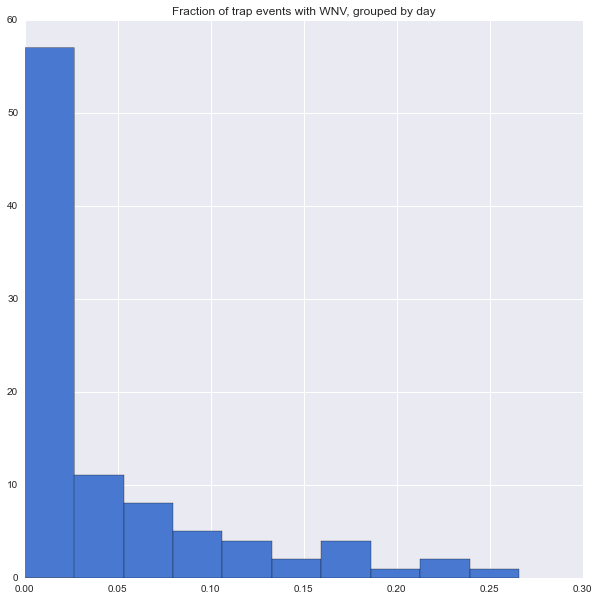

In [56]:
plt.hist(wnvByDay.mean())
plt.title("Fraction of trap events with WNV, grouped by day")

There are more extreme days, but even on these days that might be considered "outbreaks," only about 25% of trap events will have mosquitos with WNV. It's still mostly haystack and not too much needle.

We should keep in mind that, in the above histogram and elsewhere, we are always talking about the fraction of **trap events** with WNV, not the fraction of **mosquitos** with WNV. It takes only one mosquito with WNV to make WnvPresent flip to 1. In other words, days that seem "WNV-heavy" might merely be explainable -- or *predictable* -- as "mosquito-heavy." Were that the case, we would expect WNV incidence to increase as the number of mosquitos per trap rises. Let's see whether this expectation holds.

In [57]:
wnvNumByDay = trapWeatherByDay[["NumMosquitos", "WnvPresent"]]

In [58]:
wnvNumByDay.mean().head()

,NumMosquitos,WnvPresent
Date,,
2007-05-29,1.600000,0
2007-06-05,2.116667,0
2007-06-26,3.085714,0
2007-06-29,1.847826,0
2007-07-02,3.243243,0


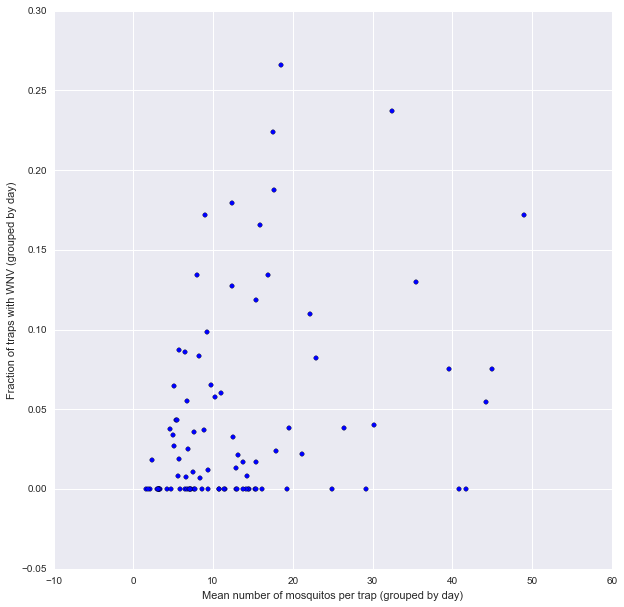

In [59]:
plt.scatter(wnvNumByDay.mean()["NumMosquitos"], wnvNumByDay.mean()["WnvPresent"])
plt.xlabel("Mean number of mosquitos per trap (grouped by day)")
plt.ylabel("Fraction of traps with WNV (grouped by day)")

The trend seems to be there: More mosquitos per trap means a higher incidence of WNV. If we average **across** days (below) rather than **within** days, the trend stands out even more.

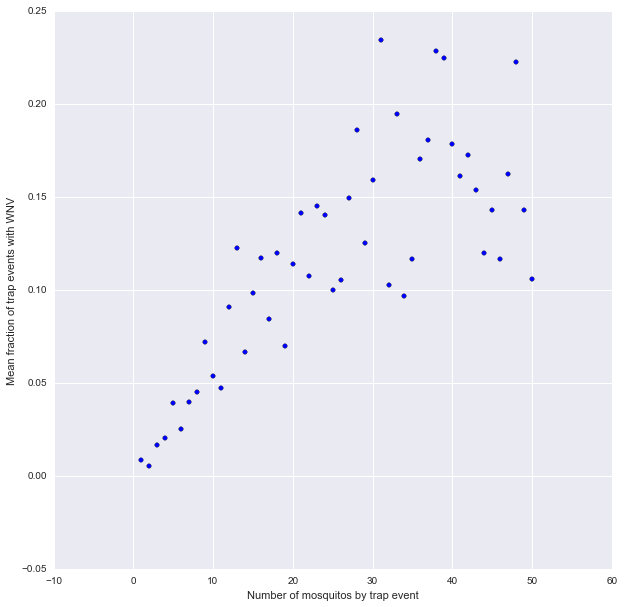

In [60]:
NumMosquitosMeanWnv = trapWeather["WnvPresent"].groupby(trapWeather["NumMosquitos"]).mean()
plt.scatter(NumMosquitosMeanWnv.index, NumMosquitosMeanWnv)
plt.xlabel("Number of mosquitos by trap event")
plt.ylabel("Mean fraction of trap events with WNV")

And yet, to reiterate, we don't have access to NumMosquitos in our testing set, so if we want to make use of this trend, we will have to infer the number of mosquitos indirectly.

Another question to ask: Are these extremes in WNV incidents spread out uniformly, or are there periods when they're more common?

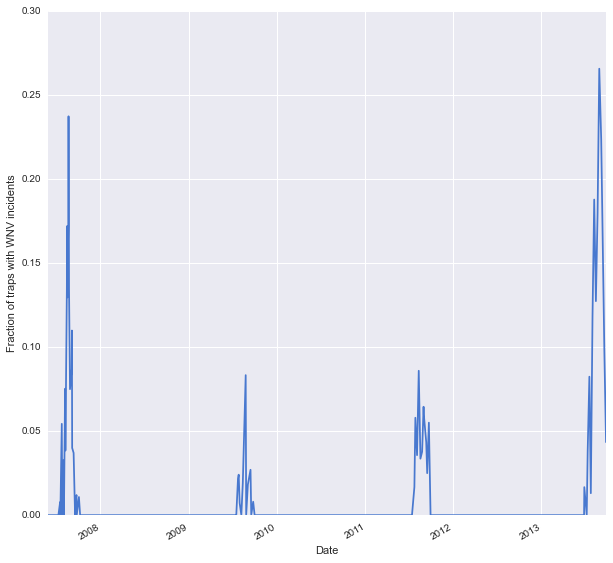

In [61]:
plt.xlabel("Date")
plt.ylabel("Fraction of traps with WNV incidents")
wnvByDay.mean().plot()

Features that we can see here:
* Each year appears to have a spike in the middle of the summer. 
* Two years definitely seem like "outbreak years," at least relative to the others. 

We would like our predictive model to take advantage of these outbreak trends, but as mentioned above, our testing data contains only "possible" records and they're for different years than the years in the training set, so we're out of luck! The hope is that outbreak trends can be marginally inferred through weather data; the weather data, least, is "real" and not "possible." 

On another note, if we were tempted to hold onto our spray data, we observe that spraying happened in 2011 and in 2013 but not in the other years. So indeed, the spraying efforts don't seem to have had much effect.

#### WNV trends vis a vis other trends 

Next question: Are WNV spikes aligned with NumMosquitos spikes? And how do both line up with the behavior of the more correlated weather variables? 

In [62]:
numByDay = trapWeatherByDay["NumMosquitos"]

In [63]:
TminByDay = trapWeatherByDay["Tmin"]

In [64]:
DewPtByDay = trapWeatherByDay["DewPoint"]

In [65]:
# Boundaries for the plots below; ugly but saves us some datetime work
year_dates = ["2007-06-07", "2007-10-15", "2009-05-29", "2009-09-29",
     "2011-05-29", "2011-09-29", "2013-05-29", "2013-09-29"]

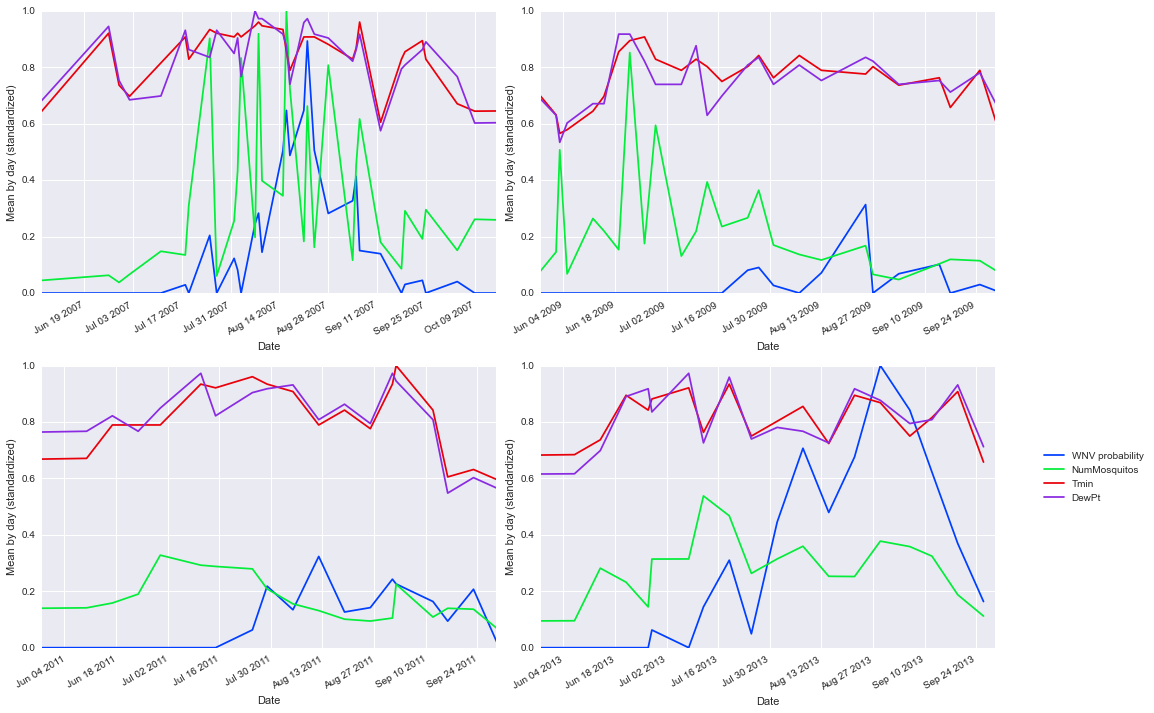

In [66]:
sns.set_palette("bright")

f, axes = plt.subplots(2, 2, figsize=(14,10))
i = 0

for ax in axes.flat:
    for k in [wnvByDay, numByDay, TminByDay, DewPtByDay]:
        (k.mean()/k.mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[i], year_dates[i+1]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Mean by day (standardized)")
    i += 2

plt.legend(["WNV probability", "NumMosquitos", "Tmin", "DewPt"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

Several interesting things to note here:

* The spikes in NumMosquitos tend to **precede** spikes in WNV, sometimes by as much as two months. This out-of-phase coordination suggests we try introducing a time lag or shift. The literature — for example, [this paper](http://www.parasitesandvectors.com/content/6/1/129) — has some guidance on appropriate values for weather variables.
* The **magnitude** of the spikes in NumMosquitos and WNV don't quite line up from year to year. Just because it's a banner year for WNV doesn't mean NumMosquitos is at a relative high; we see this in 2013. Conversely, just because there's a mosquito abundance one year doesn't mean it's a WNV outbreak year; we see this in 2009. A simple explanation for these mismatches is that there is an epidemiology for West Nile over and above mosquitos abundances and weather phenomena. That said, for the other years in our test set, the magnitudes are in step. 
* Tmin and DewPoint, as opposed to WNV, are reasonably well coordinated with NumMosquitos for year to year. (The coordination is even more evident if we take the **sum** of NumMosquitos within each day. The weather evidently explains mosquito abundances reliably, but the mosquitos get distributed across traps in a noisy manner.) So our earlier thought about using weather variables to get at NumMosquitos may work after all.



#### WNV by species

We already know that some species are far more prevalent in the trap data. What does species tell us about WNV?

In [67]:
trapWeatherBySpecies = trapWeather.groupby("Species").mean()

In [68]:
trapWeatherBySpecies["WnvPresent"]

Species
CULEX ERRATICUS           0.000000
CULEX PIPIENS             0.088922
CULEX PIPIENS/RESTUANS    0.055135
CULEX RESTUANS            0.017883
CULEX SALINARIUS          0.000000
CULEX TARSALIS            0.000000
CULEX TERRITANS           0.000000
Name: WnvPresent, dtype: float64

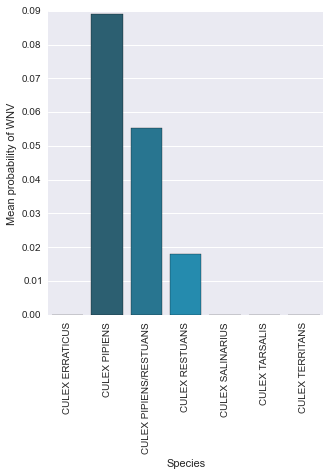

In [69]:
wnvBySpecies = trapWeatherBySpecies["WnvPresent"]
wnvBySpecies = wnvBySpecies.reset_index()
sns.factorplot("Species", "WnvPresent", data=wnvBySpecies, kind="bar", palette="PuBuGn_d")
plt.ylabel("Mean probability of WNV")
plt.xticks(rotation=90)
plt.show()

So there are really only three species that carry WNV. This variable will add more information to our model.

Next, a question about temporal trends. Does the lag between NumMosquitos and WNV that we observed above (across all species) hold on a per-species level?

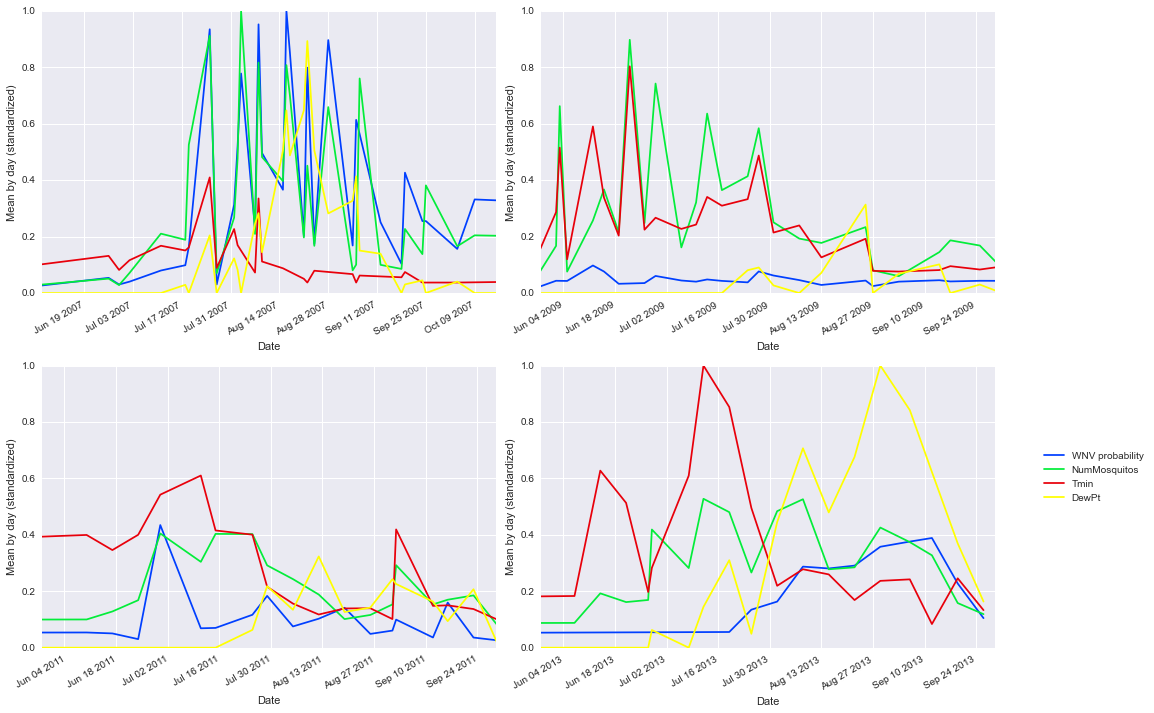

In [70]:
sns.set_palette("bright")

f, axes = plt.subplots(2, 2, figsize=(14,10))
spec = ["CULEX PIPIENS", "CULEX PIPIENS/RESTUANS", "CULEX RESTUANS"]
k = 0

for ax in axes.flat:
    for i in spec:
        f = trapWeather[trapWeather["Species"] == i].groupby("Date")
        g = f["NumMosquitos"]
        (g.mean()/g.mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[k], year_dates[k+1]))
    ax.plot((wnvByDay.mean()/wnvByDay.mean().max()).index, 
            (wnvByDay.mean()/wnvByDay.mean().max()), color="yellow")
    ax.set_xlabel("Date")
    ax.set_ylabel("Mean by day (standardized)")
    k += 2

plt.legend(["WNV probability", "NumMosquitos", "Tmin", "DewPt"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

*C. Pipiens*, the species with the highest incidence of WNV, seems better aligned with WNV spikes in the outbreak years (top left and bottom right) than the other species do. At this resolution, though, the plots are pretty noisy.

#### WNV by trap

We've seen that certain traps show up in the records more. Some related questions: 

* Do traps with many records have more mosquitos on average? 
* Do they have a higher incidence of WNV?

In [71]:
trapWeatherByTrap = trapWeather.groupby("Trap")

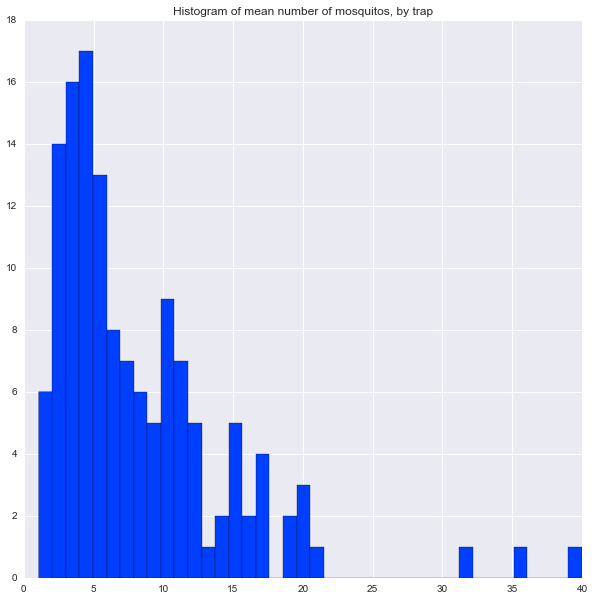

In [72]:
plt.hist(trapWeatherByTrap["NumMosquitos"].mean(), bins=40)
plt.title("Histogram of mean number of mosquitos, by trap")

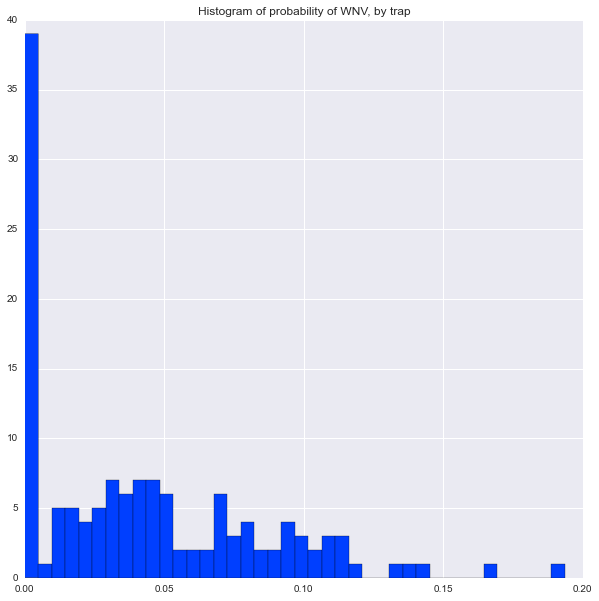

In [73]:
plt.hist(trapWeatherByTrap["WnvPresent"].mean(), bins=40)
plt.title("Histogram of probability of WNV, by trap")

So some traps are getting a lot more mosquitos on average, and some traps have a much higher incidence of WNV. Are these traps one and the same?

In [74]:
WnvNumByTrap = trapWeatherByTrap[["WnvPresent", "NumMosquitos"]]

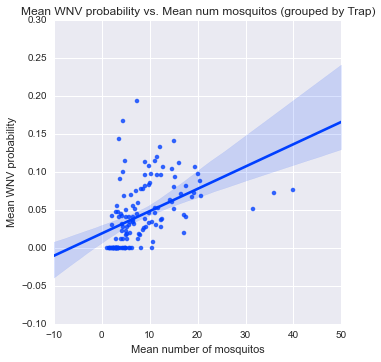

In [75]:
sns.lmplot("NumMosquitos", "WnvPresent", data=WnvNumByTrap.mean())
plt.title("Mean WNV probability vs. Mean num mosquitos (grouped by Trap)")
plt.xlabel("Mean number of mosquitos")
plt.ylabel("Mean WNV probability")
plt.show()

Not exactly. The traps that are collecting the most mosquitos don't have a particularly high WNV probability. And the traps that do have the highest WNV probabilities tend not to trap too many mosquitos. The general trend that we observed earlier — number of mosquitos is correlated with WNV probability — is still present, but there are a handful of traps bucking that trend.

#### WNV by latitude & longitude

Let's take a look at how WNV and NumMosquitos are distributed spatially compared to trap events generally. (We are going to treat latitude and longitude as rectilinear, not spherical, given how small Chicago is.)

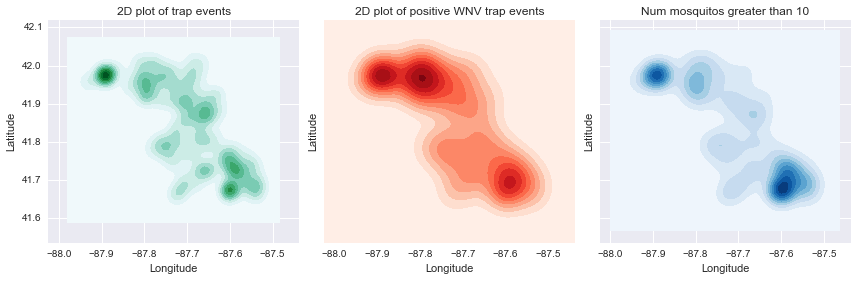

In [76]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

wnvPositive = trapWeather[trapWeather["WnvPresent"] == 1]
numMosquitosHigh = trapWeather[trapWeather["NumMosquitos"] >= 10]

sns.kdeplot(trapWeather["Longitude"], trapWeather["Latitude"], ax=ax1, shade=True)
sns.kdeplot(wnvPositive["Longitude"], wnvPositive["Latitude"], cmap="Reds", shade=True, ax=ax2)
sns.kdeplot(numMosquitosHigh["Longitude"], numMosquitosHigh["Latitude"], cmap="Blues", shade=True, ax=ax3)

ax1.set_title("2D plot of trap events")
ax2.set_title("2D plot of positive WNV trap events")
ax3.set_title("Num mosquitos greater than 10")

plt.tight_layout()
plt.show()

The plots above give credence to some of our findings thus far. Trap event abundances follow a different (but not altogether unrelated) spatial distribution relative to WNV events; WNV events, in turn, have a similar (but not altogether identical) distribution relative to NumMosquitos abundances.

To get more out of spatial variables -- and not be forced to rely on either 100+ trap variables or nonparametric latitude and longitude marginals -- we will likely need to do some clustering. This takes us to our next section.

----
## Feature transformation and extraction

Where do we stand at this point? We have a few variables that seem like they may help us predict the presence of WNV. These include the trap, the species of the mosquitos, certain weather variables such as temperature and dew point, and the number of mosquitos — a variable that, again, we will not get in our training set.

Even so, the predictive power of these variables doesn't amount to much, as the plot below (which utilizes Seaborn's default logistic regression model) hints at. Our top two candidate predictors don't lead us to even a single instance where the probability of finding WNV approaches 0.5.

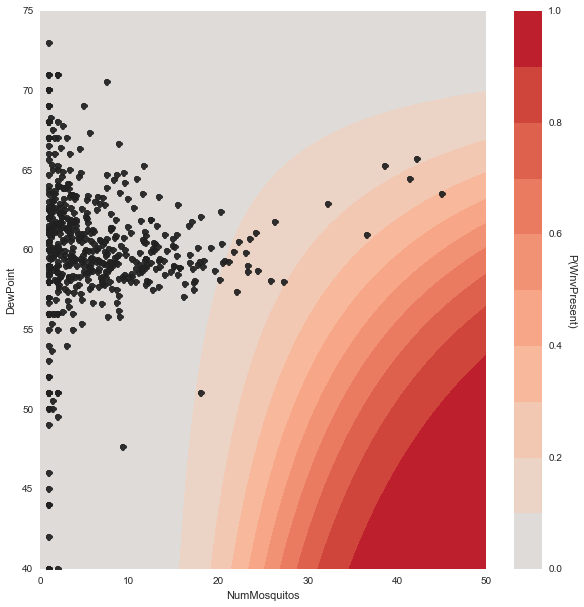

In [77]:
tmp2 = trapWeather.groupby(["Trap", "Species"]).mean()
sns.interactplot("NumMosquitos", "DewPoint", "WnvPresent", tmp2, 
                 filled=True, levels=10, cmap="coolwarm", logistic=True);

This suggests we try to transform existing features or create new features. A number of possibilities have already been discussed. Here is a more comprehensive list along with some new ideas.

* **Weather-based features**
    * *Time-lagged weather features*: We have seen evidence that weather trends precede WNV trends. One way to align the two is to do a simple time shift. However, WNV seems stable to small-scale fluctuations, so a rolling mean might work better.
    * *NumMosquitos proxy*: NumMosquitos and our leading weather predictors were very much aligned. We could attempt to create a NumMosquitos proxy variable in order to get around the absence of this variable in our test set. Then again, this inference step would likely be error-prone, and if we can find better direct correlations between WnvPresent and weather variables, we should prefer that option.
    * *Daylight time*: Though we haven't discussed this idea yet, daylight time -- i.e. sunset time minus sunrise time -- is deemed important by experts in mosquito breeding habits. Along with other weather data, it could be fed into any time lag transformation we do. 
* **Trap-based features** 
    * There are 136 traps, so to create dummy variables for each might tax any learner we try to implement. Instead, we could considering incorporating summary statistics for each trap as features. For example, we could encode a WNV probability per trap, possibly conditioned on weather variables as well.
    * We could try spatial clustering rather than deal with trap ids directly.
* **Species** 
    * We simply need to encode species via a set of dummy variables. There are only 8 species, so this shouldn't tax our model too much.

### Weather: additional features

A rolling mean of weather variables accomplishes two goals: it encodes past information, and it smoothes out small-timescale fluctuations in weather. We'll do a simple moving average rather than an exponential so that past dates are equally weighted. Leveraging the results from [this paper](http://www.parasitesandvectors.com/content/6/1/129) — see, in particular [this figure](http://www.parasitesandvectors.com/content/6/1/129/figure/F3) — we'll begin by using the following window values for the moving average:

* Temperature: 18 days
* Wind speed: 23 days
* Daylight time: 39 days
* Precipitation: 76 days
* Humidity: 106 days

We can play with different windows later to see if we get better results.

First, though, we need to compute daylight time. Recall that the trap data has only 95 unique dates over a four-year period, and so we dropped a lot of weather data when we merged our trap and weather dataframes. Let's return to the original weather dataset to compute daylight and, after that, our rolling means. Then we can merge these new variables to the trapWeather dataframe.

In [78]:
# Sunset and sunrise are encoded like 0425; let's transform that
def encode_time(s): 
    return float(s[:-2]) + float(s[-2:])/60

In [79]:
# Grab only Station 1 data
weather_1 = weather_data[weather_data["Station"] == 1]

In [80]:
# Verbose code to deal with pandas setting with copy snafus
sunset = weather_1["Sunset"].apply(lambda x: x.lstrip("0")).apply(encode_time)
weather_1.loc[:, "Sunset_float"] = np.array(sunset)

sunrise = weather_1["Sunrise"].apply(lambda x: x.lstrip("0")).apply(encode_time)
weather_1.loc[:, "Sunrise_float"] = np.array(sunrise)

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = np.nan
/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [81]:
weather_1.loc[:, "Daylight"] = weather_1["Sunset_float"] - weather_1["Sunrise_float"]

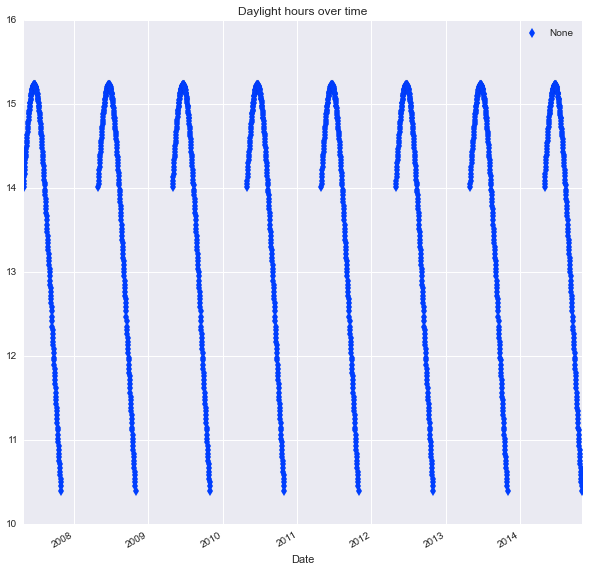

In [82]:
weather_1.plot("Date", "Daylight", style='d')
plt.title("Daylight hours over time")

That looks about right. The gaps are due to the fact that the weather data set doesn't contain records for the cold months. It would take some acrobatics to get around these discontinuities when computing our rolling mean. As a first pass, we won't worry about it.

In [83]:
def rolling_mean(df, col, window):
    movingcol = col + "Moving"
    df.loc[:, movingcol] = pd.rolling_mean(df[col], window)
    df.loc[:, movingcol] = df[movingcol].fillna(method="bfill")

In [84]:
rolling_mean(weather_1, "Tmin", 18)
rolling_mean(weather_1, "ResultSpeed", 23)
rolling_mean(weather_1, "Daylight", 39)
rolling_mean(weather_1, "PrecipTotal", 76)
rolling_mean(weather_1, "DewPoint", 106)

In [85]:
# Now let's merge this df with the original trap data and put it in a new df
trapWeatherMoving = pd.merge(trap_training_data, weather_1)

Next, we want to see if the correlations between WnvPresent and these rolling means are any stronger than they were with the original variables.

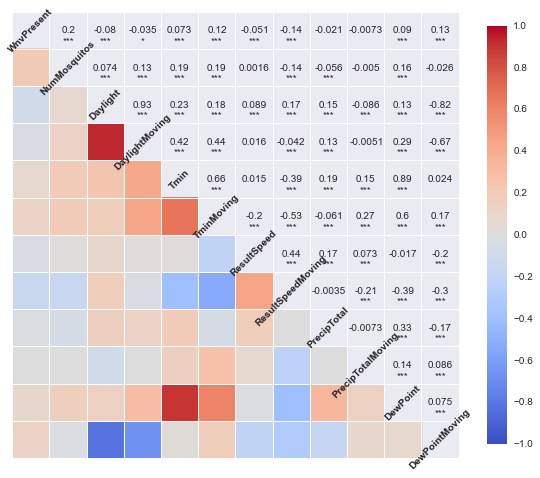

In [86]:
figsize(10,10)

sns.corrplot(trapWeatherMoving[["WnvPresent", "NumMosquitos", "Daylight", "DaylightMoving",
                         "Tmin", "TminMoving", "ResultSpeed", "ResultSpeedMoving", 
                        "PrecipTotal", "PrecipTotalMoving", "DewPoint", "DewPointMoving"]])
plt.show()

For the most part, the weather features we were considering before — Tmin, ResultSpeed, and DewPoint — all show a stronger correlation with WnvPresent than their single-day counterparts do. PrecipTotal is the exception. Daylight, which the authors of the paper said showed the strongest correlation with mosquito abundance, is less correlated with WnvPrsent than many of our other weather variables are. What's more, the correlation is **negative**. 

The correlations with NumMosquitos are more mixed. The moving versions of daylight and wind speed do better than their single-day counterparts; the moving versions of precipitation and dew point do worse.

These relatively poor correlations may be due to the details of how the correlations or rolling means were computed. We may want to try different time windows. A more likely source of noise is how our two main variables of interest,  NumMosquitos and WnvPresent, are encoded; the former is on a per-trap basis and will be subject to the noise of how mosquitos distribute themselves spatially, and the latter is binary rather than a pure probability.

Before we try out different windows, let's see how the correlation matrix looks if we smooth out some daily noise by taking the mean of trap events from the same day. (A sum might be more useful for WnvPresent, but it would be meaningless for weather variables.)

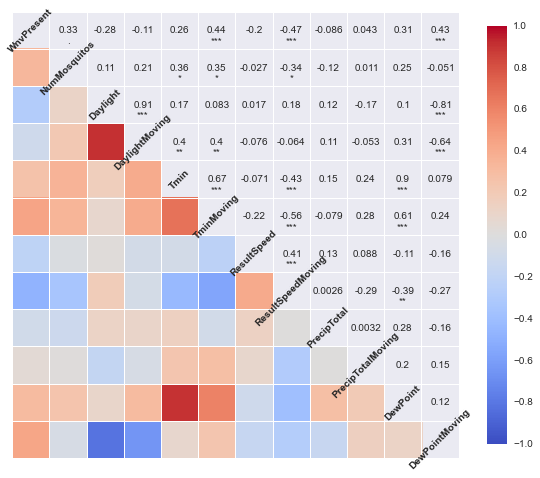

In [87]:
dayMean = trapWeatherMoving.groupby(trapWeatherMoving["Date"]).mean()

figsize(10,10)

sns.corrplot(dayMean[["WnvPresent", "NumMosquitos", "Daylight", "DaylightMoving",
                         "Tmin", "TminMoving", "ResultSpeed", "ResultSpeedMoving", 
                        "PrecipTotal", "PrecipTotalMoving", "DewPoint", "DewPointMoving"]])
plt.show()

As we might expect, the correlations get better. 

Curiously, daylight is still anti-correlated with WNV. We can imagine a story that explains this phenomenon: more daylight means more mosquitos, and more mosquitos means more WNV, but the growth of NumMosquitos outpaces the growth of WNV, and so WNV actually gets more diffuse. Thus, the **means** -- which is what we compute in the above correlation matrix -- are anti-correlated.

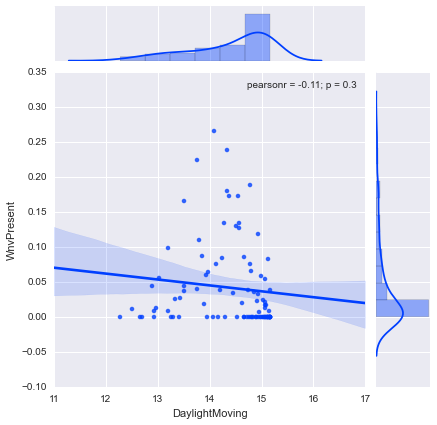

In [88]:
sns.jointplot("DaylightMoving", "WnvPresent", data=dayMean, kind="reg")

This is a plausible enough story, but if it were true, why do all the other weather variables show heightened correlations in the same direction when we take a rolling mean? Tmin gets more positively correlated with WNV, as does DewPoint, and ResultSpeed gets more negatively correlated.

Did our rolling mean get miscomputed?

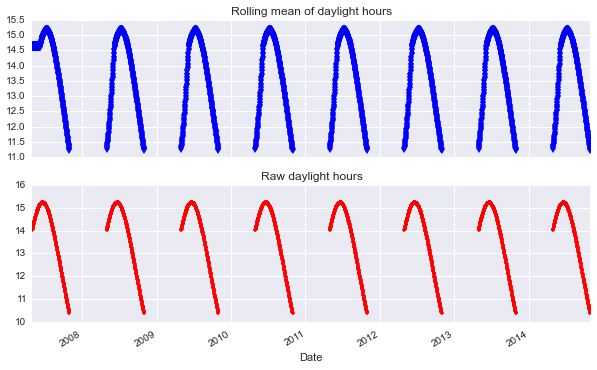

In [89]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
weather_1.plot("Date", "DaylightMoving", ax=ax1, style='bd', legend=False)
weather_1.plot("Date", "Daylight", ax=ax2, style='r.', legend=False)
ax1.set_title("Rolling mean of daylight hours")
ax2.set_title("Raw daylight hours")

No, this seems correct.

Regardless, for most weather variables, a rolling mean gives us a stronger correlation with WNV incidents than the raw variables do. When take the mean number of WNV incidents per day, and even more so when we take the sum, those correlations improve dramatically.

In our original disaggregated view, the specifics of how mosquitos are distributed spatially across traps — and even across trap events for the same trap! — introduces a fair amount of (hopefully Gaussian) noise to the problem and weakens our correlations.

Our next tactic is to tune the window size for our rolling means. Since we won't have NumMosquitos in our training set, let's optimize for the correlation with the response variable, WnvPresent, rather than keep harping on NumMosquitos. It seems reasonable, then, to try out larger time windows in order to account for the additional lag observed between mosquito spikes and WNV spikes. Let's roll our own parameter space search function to make this happen.

In [90]:
def rolling_search(df1=weather_1, df2=trap_training_data, win_start=14, win_stop=60, stride=2, col=None):
    for i in range(win_start, win_stop+1)[::stride]:
        rolling_mean(df1, col, i)
        df3 = pd.merge(df2, df1)
        movingcol = col + "Moving"
        cc = np.corrcoef(df3[movingcol].values, df3["WnvPresent"].values)[1][0]
        print movingcol, "| window :", i, "--> corr coeff =", cc

In [91]:
rolling_search(col="Tmin", win_start=10, win_stop=90, stride=2)

TminMoving | window : 10 --> corr coeff = 0.0913084963147
TminMoving | window : 12 --> corr coeff = 0.0991652268176
TminMoving | window : 14 --> corr coeff = 0.107117400115
TminMoving | window : 16 --> corr coeff = 0.112806450068
TminMoving | window : 18 --> corr coeff = 0.120027532067
TminMoving | window : 20 --> corr coeff = 0.123871654292
TminMoving | window : 22 --> corr coeff = 0.130556210852
TminMoving | window : 24 --> corr coeff = 0.132067216138
TminMoving | window : 26 --> corr coeff = 0.131472207763
TminMoving | window : 28 --> corr coeff = 0.131608833208
TminMoving | window : 30 --> corr coeff = 0.134213884652
TminMoving | window : 32 --> corr coeff = 0.137341822179
TminMoving | window : 34 --> corr coeff = 0.137124574168
TminMoving | window : 36 --> corr coeff = 0.138015309221
TminMoving | window : 38 --> corr coeff = 0.140756099944
TminMoving | window : 40 --> corr coeff = 0.141210432535
TminMoving | window : 42 --> corr coeff = 0.140886145454
TminMoving | window : 44 --> 

In [92]:
rolling_search(col="ResultSpeed", win_start=10, win_stop=50)

ResultSpeedMoving | window : 10 --> corr coeff = -0.0929699436659
ResultSpeedMoving | window : 12 --> corr coeff = -0.103361930223
ResultSpeedMoving | window : 14 --> corr coeff = -0.110808787943
ResultSpeedMoving | window : 16 --> corr coeff = -0.130315389589
ResultSpeedMoving | window : 18 --> corr coeff = -0.125646930387
ResultSpeedMoving | window : 20 --> corr coeff = -0.131153465232
ResultSpeedMoving | window : 22 --> corr coeff = -0.13543328099
ResultSpeedMoving | window : 24 --> corr coeff = -0.142251943245
ResultSpeedMoving | window : 26 --> corr coeff = -0.148332780513
ResultSpeedMoving | window : 28 --> corr coeff = -0.149104823657
ResultSpeedMoving | window : 30 --> corr coeff = -0.152434725045
ResultSpeedMoving | window : 32 --> corr coeff = -0.156049730643
ResultSpeedMoving | window : 34 --> corr coeff = -0.153648599105
ResultSpeedMoving | window : 36 --> corr coeff = -0.15047444064
ResultSpeedMoving | window : 38 --> corr coeff = -0.15091058031
ResultSpeedMoving | window 

In [93]:
rolling_search(col="Daylight", win_start=10, win_stop=100, stride=5)

DaylightMoving | window : 10 --> corr coeff = -0.0735442893802
DaylightMoving | window : 15 --> corr coeff = -0.069398354227
DaylightMoving | window : 20 --> corr coeff = -0.0645233586088
DaylightMoving | window : 25 --> corr coeff = -0.0589676839917
DaylightMoving | window : 30 --> corr coeff = -0.0522044239377
DaylightMoving | window : 35 --> corr coeff = -0.04357715937
DaylightMoving | window : 40 --> corr coeff = -0.0323262793889
DaylightMoving | window : 45 --> corr coeff = -0.0189845073482
DaylightMoving | window : 50 --> corr coeff = -0.00279207758405
DaylightMoving | window : 55 --> corr coeff = 0.0152966161063
DaylightMoving | window : 60 --> corr coeff = 0.0341801275065
DaylightMoving | window : 65 --> corr coeff = 0.052501843047
DaylightMoving | window : 70 --> corr coeff = 0.0688043886093
DaylightMoving | window : 75 --> corr coeff = 0.0852539330095
DaylightMoving | window : 80 --> corr coeff = 0.101575274177
DaylightMoving | window : 85 --> corr coeff = 0.114275539997
Dayl

In [94]:
rolling_search(col="PrecipTotal", win_start=40, win_stop=100, stride=5)

PrecipTotalMoving | window : 40 --> corr coeff = -0.00619596218507
PrecipTotalMoving | window : 45 --> corr coeff = -0.00786255779739
PrecipTotalMoving | window : 50 --> corr coeff = -0.0201620244388
PrecipTotalMoving | window : 55 --> corr coeff = -0.0281499479395
PrecipTotalMoving | window : 60 --> corr coeff = -0.0257398657912
PrecipTotalMoving | window : 65 --> corr coeff = -0.0181683408517
PrecipTotalMoving | window : 70 --> corr coeff = -0.022157552684
PrecipTotalMoving | window : 75 --> corr coeff = -0.0104023246916
PrecipTotalMoving | window : 80 --> corr coeff = -0.0020068530522
PrecipTotalMoving | window : 85 --> corr coeff = 0.00227901853931
PrecipTotalMoving | window : 90 --> corr coeff = 0.00789058960445
PrecipTotalMoving | window : 95 --> corr coeff = 0.00740864048586
PrecipTotalMoving | window : 100 --> corr coeff = -0.0102269256632


In [95]:
rolling_search(col="DewPoint", win_start=40, win_stop=100, stride=5)

DewPointMoving | window : 40 --> corr coeff = 0.149275092135
DewPointMoving | window : 45 --> corr coeff = 0.150671801653
DewPointMoving | window : 50 --> corr coeff = 0.152339752851
DewPointMoving | window : 55 --> corr coeff = 0.157334695854
DewPointMoving | window : 60 --> corr coeff = 0.160981502733
DewPointMoving | window : 65 --> corr coeff = 0.162205122429
DewPointMoving | window : 70 --> corr coeff = 0.16465784846
DewPointMoving | window : 75 --> corr coeff = 0.167526641714
DewPointMoving | window : 80 --> corr coeff = 0.168189039663
DewPointMoving | window : 85 --> corr coeff = 0.168762059973
DewPointMoving | window : 90 --> corr coeff = 0.16372167542
DewPointMoving | window : 95 --> corr coeff = 0.157376812334
DewPointMoving | window : 100 --> corr coeff = 0.146013706351


Great, now we have some better candidates for the rolling mean windows for each weather variable. PrecipTotal was a bit all over the map, suggesting that it's not a good predictor. That leaves us with the following windows:

* Tmin: 70 days
* ResultSpeed: 32 days
* Daylight: 100 days
* DewPoint: 85 days

We could take an even longer window for daylight, since it was still increasing at 100 days, but we probably don't want to incorporate the readings from the previous year, nor do we want our forward-fill imputation process to trip us up. Let's encode our chosen windows and look again at the correlation matrix.

In [96]:
rolling_mean(weather_1, "Tmin", 70)
rolling_mean(weather_1, "ResultSpeed", 32)
rolling_mean(weather_1, "Daylight", 100)
rolling_mean(weather_1, "DewPoint", 85)

In [97]:
trapWeatherMoving = pd.merge(trap_training_data, weather_1)

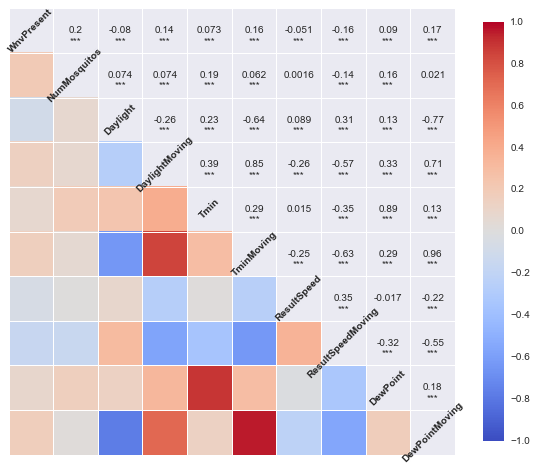

In [98]:
figsize(10, 10)
sns.corrplot(trapWeatherMoving[["WnvPresent", "NumMosquitos", "Daylight", "DaylightMoving",
                                "Tmin", "TminMoving", "ResultSpeed", "ResultSpeedMoving", 
                                "DewPoint", "DewPointMoving"]])
plt.show()

We're doing slightly better, it seems. Next, we'll plot some time series for a sanity check on how our rolling means correlate with NumMosquitos and WNV.

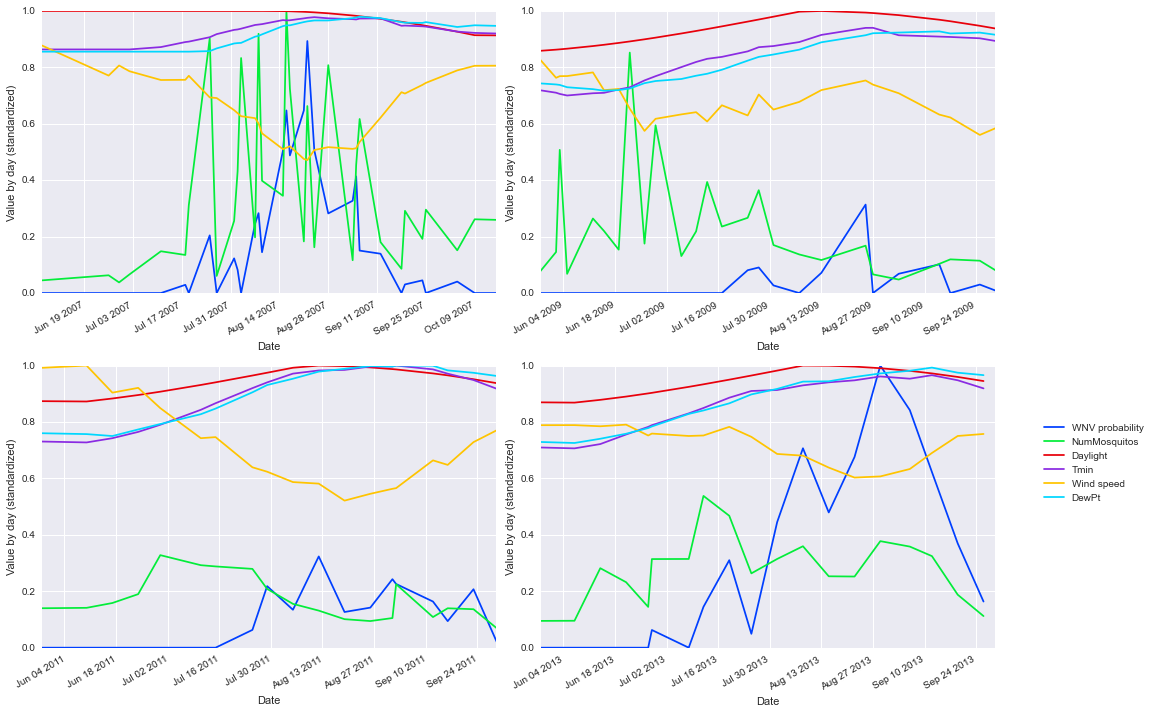

In [99]:
sns.set_palette("bright")

trapWeatherMovingByDay = trapWeatherMoving.groupby("Date")
df = trapWeatherMovingByDay # for brevity's sake
features = ["WnvPresent", "NumMosquitos", "DaylightMoving", 
             "TminMoving", "ResultSpeedMoving", "DewPointMoving"]

f, axes = plt.subplots(2, 2, figsize=(14,10))
j = 0
for ax in axes.flat:
    for k in features:
        (df[k].mean()/df[k].mean().max()).plot(sharex=False, ax=ax, 
                                       xlim=(year_dates[j], year_dates[j+1]))
    ax.set_xlabel("Date")
    ax.set_ylabel("Value by day (standardized)")
    j += 2

plt.legend(["WNV probability", "NumMosquitos", "Daylight", "Tmin", "Wind speed", "DewPt"], loc=(1.1,0.5))
plt.tight_layout()
plt.show()

The good news is that at a large enough scale, the rolling means of the weather variables now align reasonably well with WNV. What we've done, essentially, is replace the need for date as a variable by extracting the same information, if not better information, from the weather. The bad news is that we've smoothed out a lot of the small-scale variability in the process. WNV outbreaks are spiky affairs. If we want our model to have a low Type II error rate, we'll need to be sensitive to these spikes.

Adding a simple time shift of highly correlated weather variables -- in addition to our rolling means -- might give us a way to account for both large-scale and small-scale structure. Howeer, before we go too far down the rabbit hole building out our feature set, it would be wise to build an initial model and get a performance baseline. The last thing we'll do before we start that process is add species to our feature set.

### Species: additional features

Species is a categorical variable and requires transformation before we feed it into a model. 

In [100]:
dummies = pd.get_dummies(trapWeatherMoving[["Species"]])

In [101]:
trapWeatherMovingDummies = trapWeatherMoving.join(dummies)

In [102]:
trapWeatherMovingDummies.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,...,DaylightMoving,PrecipTotalMoving,DewPointMoving,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX PIPIENS/RESTUANS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506,10506.000000,10506.000000,10506.000000,...,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446,1,81.847992,62.716067,72.530459,...,14.287364,0.143630,55.330663,0.000095,0.256901,0.452313,0.260803,0.008186,0.000571,0.021131
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936,0,8.278380,7.677123,7.523979,...,0.587986,0.036374,4.924583,0.009756,0.436945,0.497744,0.439094,0.090109,0.023892,0.143827
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000,1,57.000000,41.000000,50.000000,...,12.719000,0.081400,44.494118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000,1,78.000000,58.000000,69.000000,...,13.942500,0.113600,52.458824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000,1,83.000000,64.000000,74.000000,...,14.447667,0.135800,56.552941,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000,1,88.000000,69.000000,78.000000,...,14.811000,0.155900,59.564706,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000,1,96.000000,76.000000,84.000000,...,14.823833,0.252400,62.035294,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


--------------

##Model creation: first iteration

We now have a data set that is suitably cleaned and possesses some additional features for consideration. It's time to build a model and see how we do. We can add more features and do more serious transformation of our original features after this first pass.

### Setup

Let's separate our variables into distinct lists according to how promising they are as features. We'll then feed select features through a small set of models and see how different tunings do. Scikit-learn's GridSearchCV feature will be useful here and will save us the trouble of doing cross-validation. 

Now is also a good time to recall that we do **not** have access to NumMosquitos in our training set. For this reason, we will build our initial model without using NumMosquitos as a feature. Once we feel we have done a decent search through the solution space, we can investigate how adding proxies for NumMosquitos affects the performance of our model. At that point, we may return to the Poisson fit from earlier.

In [103]:
good_vars = ["TminMoving", "DewPointMoving", "DaylightMoving", "ResultSpeedMoving"] + list(dummies.columns)

unmoving_vars = ["Tmin", "DewPoint", "Daylight", "ResultSpeed"]

spatial_vars = ["Latitude", "Longitude"]

unsure_vars = ["PrecipTotalMoving", "ResultDir"]

date_vars = ["Date"]

bad_vars = ["WnvPresent", "NumMosquitos", "Tavg", "Address", "Date", "Block", "Street", 
            "AddressNumberAndStreet", "Trap", "Species", "Tavg", "AvgSpeed", "Depart", 
            "CodeSum", "StnPressure", "SeaLevel", "Depth", "Water1", "SnowFall", "WetBulb", 
            "Heat", "Cool", "ResultDir", "Station", "Sunrise_float", "Sunset_float", 
            "AddressAccuracy", "Station", "Sunrise", "Sunset"]

In [104]:
# Labels data; this is what we're trying to predict
labels_data = np.array(trapWeatherMovingDummies['WnvPresent'])

In [105]:
# Import some useful packages
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [106]:
# Helper function for getting standardized array of desired features; pass in any concatenation of lists above
def feat_array(featlist, df=trapWeatherMovingDummies):
    f_array = np.array(df[featlist])
    f_data = preprocessing.StandardScaler().fit(f_array).transform(f_array)
    return f_data

### "Good" variables

We'll begin by running our most promising features through a select set of ML algorithms. Note that the `feat_array` helper function defined above standardizes all features using sklearn's `preprocessing` package.

In [107]:
features_data_1 = feat_array(good_vars)

In [108]:
X1_train, X1_test, y_train, y_test = train_test_split(
    features_data_1, labels_data, test_size = 0.50, random_state=42)

The classes of algorithms that seem most appropriate for our problem are:

* SVM classifier — SVMs work well for a variety of use cases. The caveats are that they are inherently linear, they struggle with non-normally distributed features, and they expect features to be uncorrelated. We don't expect our features to combine linearly, at least not necessarily, and we expect many of them to be correlated.  
* k-nearest neighbors — A k-NN learner makes no assumptions about the distributions of the features. On the minus side, the notion of a distance metric in high-dimensional space is always a bit fuzzy, and k-NN will suffer if we introduce additional features later. 
* Logistic regression — Logistic regression is worth a try given the binary nature of the response variable. Like k-NN, it makes no assumptions about the distributions of the features.
* Decision tree — A simple choice but not a bad one. The class imbalance may cause us trouble.

#### SVM classifiers

In [109]:
from sklearn import svm

Below, we define model tunings as a list of dictionaries for use in grid search. Our performance metric is the ROC AUC score.

In [110]:
# Parameter search space; use class_weight = "auto" to handle imbalanced classes
svm_tunings = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 
                     'C': [1, 10, 100], 'class_weight': ['auto']},
                    {'kernel': ['linear'], 'C': [1, 10, 100], 'class_weight': ['auto']},
                    {'kernel': ['poly'], 'degree': [1, 2, 3, 4], 
                     'C': [1, 10, 100], 'class_weight': ['auto']}]

In [111]:
# Train the model
svm_clf = GridSearchCV(svm.SVC(probability=True), svm_tunings, score_func=roc_auc_score, cv=10)
svm_clf.fit(X1_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'C': [1, 10, 100], 'gamma': [0.001, 0.0001], 'class_weight': ['auto']}, {'kernel': ['linear'], 'C': [1, 10, 100], 'class_weight': ['auto']}, {'kernel': ['poly'], 'C': [1, 10, 100], 'degree': [1, 2, 3, 4], 'class_weight': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [112]:
# Our best estimator is...
svm_clf.best_estimator_

SVC(C=100, cache_size=200, class_weight='auto', coef0=0.0, degree=3,
  gamma=0.0, kernel='poly', max_iter=-1, probability=True,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

This result is a bit suspicious. The penalty term, C, of our best estimator has a high value, and the kernel is a third-degree polynomial. Although we've done 10-fold cross-validation — that's what the `cv` parameter in GridSearchCV is doing — this feels like overfitting.

In [113]:
svm_clf_pred = svm_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, svm_clf_pred[:, 1])

AUC score: 0.802722905033


In [114]:
# Helper function to plot ROC curve
def plot_roc_curve(pred):
    figsize(8, 6)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

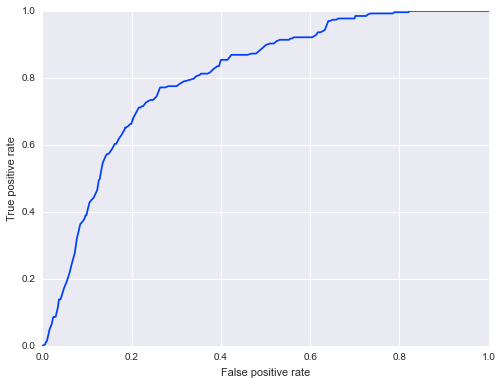

In [115]:
plot_roc_curve(svm_clf_pred)

#### k-nearest neighbors

In [116]:
from sklearn.neighbors import KNeighborsClassifier

In [117]:
# Parameter search space; use class_weight = "auto" to handle imbalanced classes
knn_tunings = [{'weights': ['uniform', 'distance'], "n_neighbors": [1, 2, 3, 5, 10, 25, 50]}]

In [118]:
# Train the model
knn_clf = GridSearchCV(KNeighborsClassifier(), knn_tunings, score_func=roc_auc_score, cv=10)
knn_clf.fit(X1_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'n_neighbors': [1, 2, 3, 5, 10, 25, 50], 'weights': ['uniform', 'distance']}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [119]:
# Best estimator
knn_clf.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=10, p=2, weights='uniform')

In [120]:
knn_clf_pred = knn_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, knn_clf_pred[:, 1])

AUC score: 0.703029531377


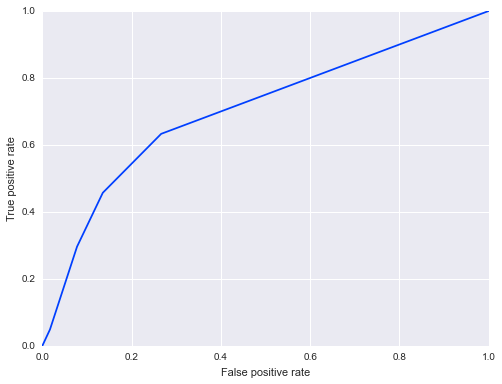

In [121]:
plot_roc_curve(knn_clf_pred)

#### Logistic regression

In [122]:
from sklearn import linear_model

In [123]:
lr_tunings = [{'C': [1, 10, 100, 1000], 'class_weight': ['auto']}]

In [124]:
lr_clf = GridSearchCV(linear_model.LogisticRegression(), lr_tunings, score_func=roc_auc_score, cv=10)
lr_clf.fit(X1_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'C': [1, 10, 100, 1000], 'class_weight': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [125]:
# Our best estimator
lr_clf.best_estimator_

LogisticRegression(C=10, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [126]:
lr_clf_pred = lr_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, lr_clf_pred[:, 1])

AUC score: 0.799317114137


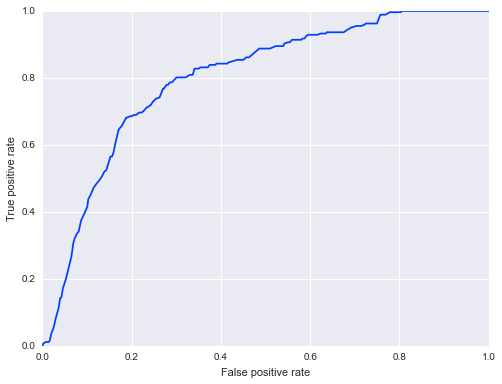

In [127]:
plot_roc_curve(lr_clf_pred)

#### Decision trees

In [128]:
from sklearn.tree import DecisionTreeClassifier

In [129]:
dt_tunings = [{"criterion": ["gini", "entropy"], "class_weight": ["auto"],
              "min_samples_split": [1, 2, 5, 10, 50], 
               "min_samples_leaf": [1, 2, 5, 10, 50]}]

In [130]:
dt_clf = GridSearchCV(DecisionTreeClassifier(), dt_tunings, score_func=roc_auc_score, cv=10)
dt_clf.fit(X1_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid=[{'min_samples_split': [1, 2, 5, 10, 50], 'min_samples_leaf': [1, 2, 5, 10, 50], 'criterion': ['gini', 'entropy'], 'class_weight': ['auto']}],
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [131]:
# Our best estimator
dt_clf.best_estimator_

DecisionTreeClassifier(class_weight='auto', criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

In [132]:
dt_clf_pred = dt_clf.best_estimator_.predict_proba(X1_test)
print "AUC score:", roc_auc_score(y_test, dt_clf_pred[:, 1])

AUC score: 0.790950992367


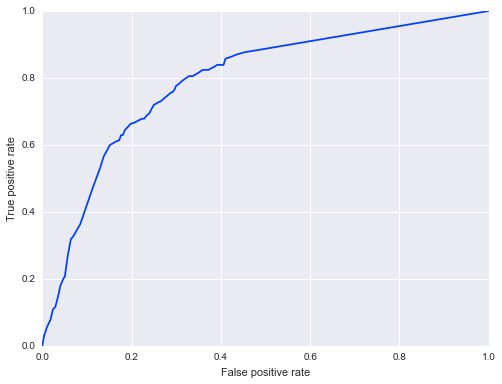

In [133]:
plot_roc_curve(dt_clf_pred)

#### Summary of "good" features

Our best-performing algorithms was the SVM, whose AUC score topped 0.8. We can consider this barely "good" but far from "excellent." The logistic regression model and the decision tree did comparably well. The k-nearest neighbors model fared worst.

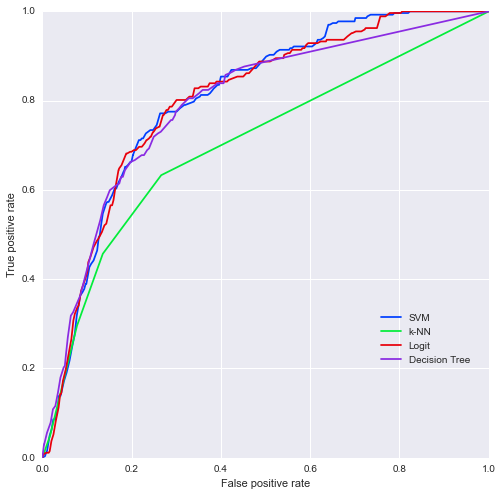

In [134]:
figsize(8, 8)

for k in [svm_clf_pred, knn_clf_pred, lr_clf_pred, dt_clf_pred]:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, k[:, 1])
    plt.plot(fpr, tpr)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(["SVM", "k-NN", "Logit", "Decision Tree"], loc=(0.75,0.2))
plt.show()

Since k-nearest neighbors is likely to do even worse as we add more features, we have an argument for dropping it outright.

## Coming attractions

Our AUC score is good but not excellent. We have several choices for how to proceed, including:

* Throw some additional features (e.g. lat/lon) into our first set of models
* Run our initial feature set through different models — an ensemble learner such as a random forest, perhaps
* Do a time-shift on weather variables to get at small-timescale phenomena, or attempt a more complex Fourier transform
* Try some trap-based clustering to see if we can get around having to add 100+ dummy dimensions
* Extract a proxy for NumMosquitos, using weather data and/or trap-based clustering

Stay tuned...